In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, DataCollatorForLanguageModeling, get_cosine_schedule_with_warmup
from datasets import load_dataset

from attentif.mini_bert import MaskedLM

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
warmup_step_ratio = 0.01
num_epochs = 20
batch_size = 32
max_length = 512

In [3]:
dataset = load_dataset("allenai/c4", "realnewslike", split="train[:1000]")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
collator = DataCollatorForLanguageModeling(tokenizer)

dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        truncation=True,
        max_length=max_length,
    ),
    remove_columns=dataset.column_names,
    batched=True,
);

batches = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collator)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

In [4]:
model = MaskedLM(tokenizer.vocab_size, tokenizer.pad_token_id)
device = torch.device("mps")
model = model.to(device)

In [5]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

num_training_steps = num_epochs * len(batches)
num_warmup_steps = int(num_training_steps * warmup_step_ratio)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

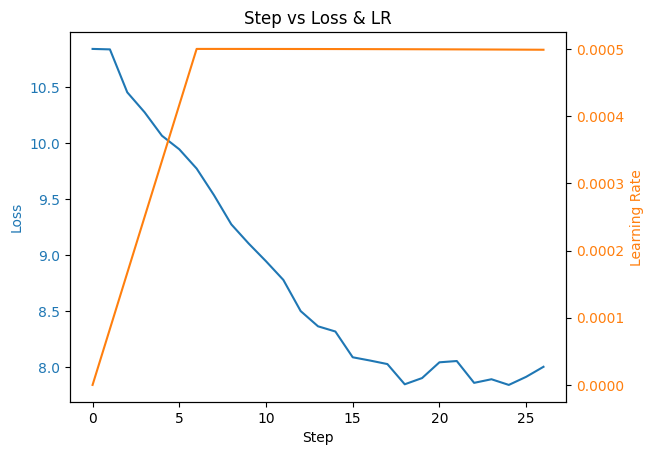

In [ ]:
model.train()

losses = []
lrs = []

def visualize():
    clear_output(wait=True)
    
    fig, ax1 = plt.subplots()
    
    # 左軸: loss
    ax1.plot(losses, color="tab:blue")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    
    # 右軸: learning rate
    ax2 = ax1.twinx()
    ax2.plot(lrs, color="tab:orange")
    ax2.set_ylabel("Learning Rate", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    
    plt.title("Step vs Loss & LR")
    plt.show()

for epoch in tqdm(range(0, num_epochs)):
    for batch in batches:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # 1/0 を 0/-inf に変換
        attention_mask = torch.where(attention_mask == 1, 0, -torch.inf)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        lrs.append(optimizer.param_groups[0]["lr"]) 
        
        optimizer.step()
        scheduler.step()
    
        losses.append(loss.item())

        visualize()